In [3]:
# import jax
# jax.config.update('jax_enable_x64',True)
# # jax.config.update("jax_default_device", jax.devices()[6])
# import jax.numpy as jnp
import pandas as pd
# from jax.random import PRNGKey as pkey
# from jax.scipy.special import expit
# from jaxopt import LBFGS
# import statsmodels.api as sm
# from tqdm.auto import tqdm
# from functools import partial
# from scipy.optimize import root_scalar,minimize_scalar

import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from correlation_correction.methods import gl_methods as gl
from correlation_correction.methods import hamling_methods as ham
from correlation_correction.regressions import gls_reg, wls_reg

In [ ]:
@jax.jit
def margin_like(gamma,covariance_matrices,Y,X,Z):
    ZZT = Z@Z.T
    vmats = jnp.array([ZZT*gamma + C for C in covariance_matrices])
    inv_vmats = jnp.array([jnp.linalg.inv(V) for V in vmats])
    LNV = jnp.sum(jnp.array([logdet(V) for V in vmats]))
    beta = (
        jnp.linalg.inv(jnp.sum(jnp.array([X.T@inv_V@X for inv_V in inv_vmats]),axis=0))@ 
        (jnp.sum(jnp.array([X.T@inv_V@y for inv_V,y in zip(inv_vmats,Y)]),axis=0))
    )
    res_term = jnp.sum(
        jnp.array([
            (X@beta - y).T@inv_v@(X@beta-y) 
            for inv_v,y in zip(inv_vmats,Y)])
        )
    return LNV+res_term

@jax.jit
def margin_like_reml(gamma,covariance_matrices,Y,X,Z):
    ZZT = Z@Z.T
    vmats = jnp.array([ZZT*gamma + C for C in covariance_matrices])
    inv_vmats = jnp.array([jnp.linalg.inv(V) for V in vmats])
    LNV = jnp.sum(jnp.array([logdet(V) for V in vmats]))
    REML_term = jnp.log(jnp.sum(jnp.array([X.T@invV@X for invV in inv_vmats])))
    beta = (
        jnp.linalg.inv(jnp.sum(jnp.array([X.T@inv_V@X for inv_V in inv_vmats]),axis=0))@ 
        (jnp.sum(jnp.array([X.T@inv_V@y for inv_V,y in zip(inv_vmats,Y)]),axis=0))
    )
    res_term = jnp.sum(
        jnp.array([
            (X@beta - y).T@inv_v@(X@beta-y) 
            for inv_v,y in zip(inv_vmats,Y)])
        )
    return LNV + res_term + REML_term
vec_reml_like = (
    jax.vmap(margin_like_reml,in_axes=[0,None,None,None,None])
)
diff_reml_like = jax.jit(
    jax.grad(margin_like_reml,argnums=0)
)
diff_margin_like = jax.jit(
    jax.grad(margin_like,argnums=0)
)
vec_margin_like = (
    jax.vmap(margin_like,in_axes=[0,None,None,None,None])
)


def estimate_gamma(L_vals,cov_mats,X,Z):
    gamma_grid = jnp.logspace(-4,2.,20)
    try:
        gamma = root_scalar(lambda x:diff_margin_like(x,cov_mats,L_vals,X,Z),bracket = (1e-3,10.)).root
    except:
        nll = vec_margin_like(gamma_grid,cov_mats,L_vals,X,Z)
        gamma = gamma_grid[jnp.argmin(nll)]
    ZZT = Z@Z.T
    vmats = jnp.array([ZZT*gamma + C for C in cov_mats])
    inv_vmats = jnp.array([jnp.linalg.inv(V) for V in vmats])
    beta = (
        jnp.linalg.inv(jnp.sum(jnp.array([X.T@inv_V@X for inv_V in inv_vmats]),axis=0))@ 
        (jnp.sum(jnp.array([X.T@inv_V@y for inv_V,y in zip(inv_vmats,L_vals)]),axis=0))
    )
    return jnp.array(gamma),beta[0]

In [4]:
# Reading in data and removing trimmed point from model
study_df = pd.read_excel("/Users/verano13/Documents/CorrelationCorrection/SBPvPAD_data.xlsx")
to_exclude = study_df.index.isin([4])
study_df = study_df[~to_exclude]
study_df.reset_index(inplace=True)
study_df = study_df.iloc[:,1:]

# Getting log odds ratios
study_df.iloc[0,5:8] = np.log(study_df.iloc[0,5:8].to_numpy().astype(np.float64))
study_df.iloc[4,5:8] = np.log(study_df.iloc[4,5:8].to_numpy().astype(np.float64))

# Get study specific data -- Hamling (and only Hamling) -- Stoekenbroek
L_s = study_df[study_df["Author"] == "Stoekenbroek"]["logOR"].to_numpy()[1:]
x_s = study_df[study_df["Author"] == "Stoekenbroek"]["dose"].to_numpy()[1:] - study_df["dose"][0]
v_s = (study_df[study_df["Author"] == "Stoekenbroek"]["std_error"].to_numpy()[1:])**2
A_s_sum = study_df[study_df["Author"] == "Stoekenbroek"]["cases"].sum()
B_s_sum = study_df[study_df["Author"] == "Stoekenbroek"]["controls"].sum()
b0_s = study_df[study_df["Author"] == "Stoekenbroek"]["controls"][0]
p_s = b0_s / B_s_sum
z_s = B_s_sum / A_s_sum

# Get study specific data -- Hamling (and only Hamling) -- Itoga
L_i = study_df[study_df["Author"] == "Itoga"]["logOR"].to_numpy()[1:]
x_i = study_df[study_df["Author"] == "Itoga"]["dose"].to_numpy()[1:] - study_df["dose"][4]
v_i = (study_df[study_df["Author"] == "Itoga"]["std_error"].to_numpy()[1:])**2
A_i_sum = study_df[study_df["Author"] == "Itoga"]["cases"].sum()
B_i_sum = study_df[study_df["Author"] == "Itoga"]["controls"].sum()
b0_i = study_df[study_df["Author"] == "Itoga"]["controls"][4]
p_i = b0_i / B_i_sum
z_i = B_i_sum / A_i_sum

# Get odds ratios and exposures for each study
L = np.hstack((L_s, L_i))
x = np.hstack((x_s, x_i))
v = np.hstack((v_s,v_i))


In [7]:
study_df

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
0,Stoekenbroek,114.0,21.000000,5428.500000,5449.5,0.000,0.0000,0.000,0.000000
1,Stoekenbroek,128.0,39.000000,5410.500000,5449.5,0.410,0.2200,0.590,0.093434
2,Stoekenbroek,139.0,51.000000,5398.500000,5449.5,0.440,0.2700,0.620,0.088384
3,Stoekenbroek,159.0,116.000000,5333.500000,5449.5,1.080,0.9900,1.170,0.045455
4,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
5,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
6,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
7,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
8,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [5]:
# Get counts from Hamling method for both studies
counts_s = ham.hamling(L_s,p_s,z_s,v_s)
counts_i = ham.hamling(L_i,p_i,z_i,v_i)

# Get covariance matrices from both studies
C_s = counts_s.cov(v_s)
C_i = counts_i.cov(v_i)

# Get block diagonal matrix of covariances
C = block_diag(C_s, C_i)

In [6]:
# Perfrom generalized regression
b_star, v_star = gls_reg(C,L,x)

# Perfrom regression weighted by reported variances
b, v = wls_reg(L,x,v)

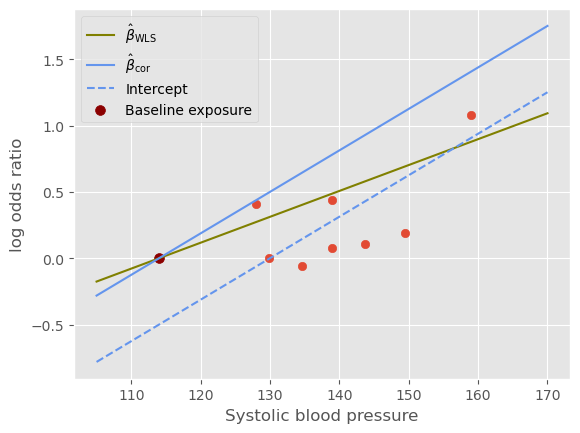

In [12]:
# Perform plot
def slope_fn(beta,x):
    return beta*(x-114)

xs = np.linspace(105,170)

# plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
# # plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
# plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
# plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(xs,slope_fn(b,xs),label=r"$\hat \beta_{\mathrm{WLS}}$",c="olive")
plt.plot(xs,slope_fn(b_star,xs),label=r"$\hat \beta_{\mathrm{cor}}$",c="cornflowerblue")
plt.plot(xs,slope_fn(b_star,xs)-0.5,label="Intercept",linestyle="dashed",c="cornflowerblue")
plt.scatter(study_df["dose"],study_df["logOR"])
plt.scatter(114.,0,c="darkred",s=50,label="Baseline exposure")
plt.ylabel("log odds ratio")
plt.xlabel("Systolic blood pressure")
plt.legend()
# plt.savefig("images/itoga_regression.pdf",bbox_inches="tight",pad_inches=0.1)
plt.show()